# 📝 Pattern Recognition & Biometrics. TP Régression

Par Omar Galarraga et Sonia Garcia

L'objectif de ce travail pratique est de réaliser des tâches de régression : 

* Linéaire simple
* Multilinéaire (avec et sans régularisation)
* Non linéaire avec réseaux de neurones

Nous voudrons prédire le prix médian des maisons californiennes par quartier en fonction de plusieurs variables quantitatives. 

Commençons par charger les données et regarder la description de la base de données :


In [1]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

california_housing = fetch_california_housing(as_frame=True)

print(california_housing.frame.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


* 0.1) Montrez l'histogramme des variables (Piste : *california_housing.frame* contient un DataFrame de Pandas) 

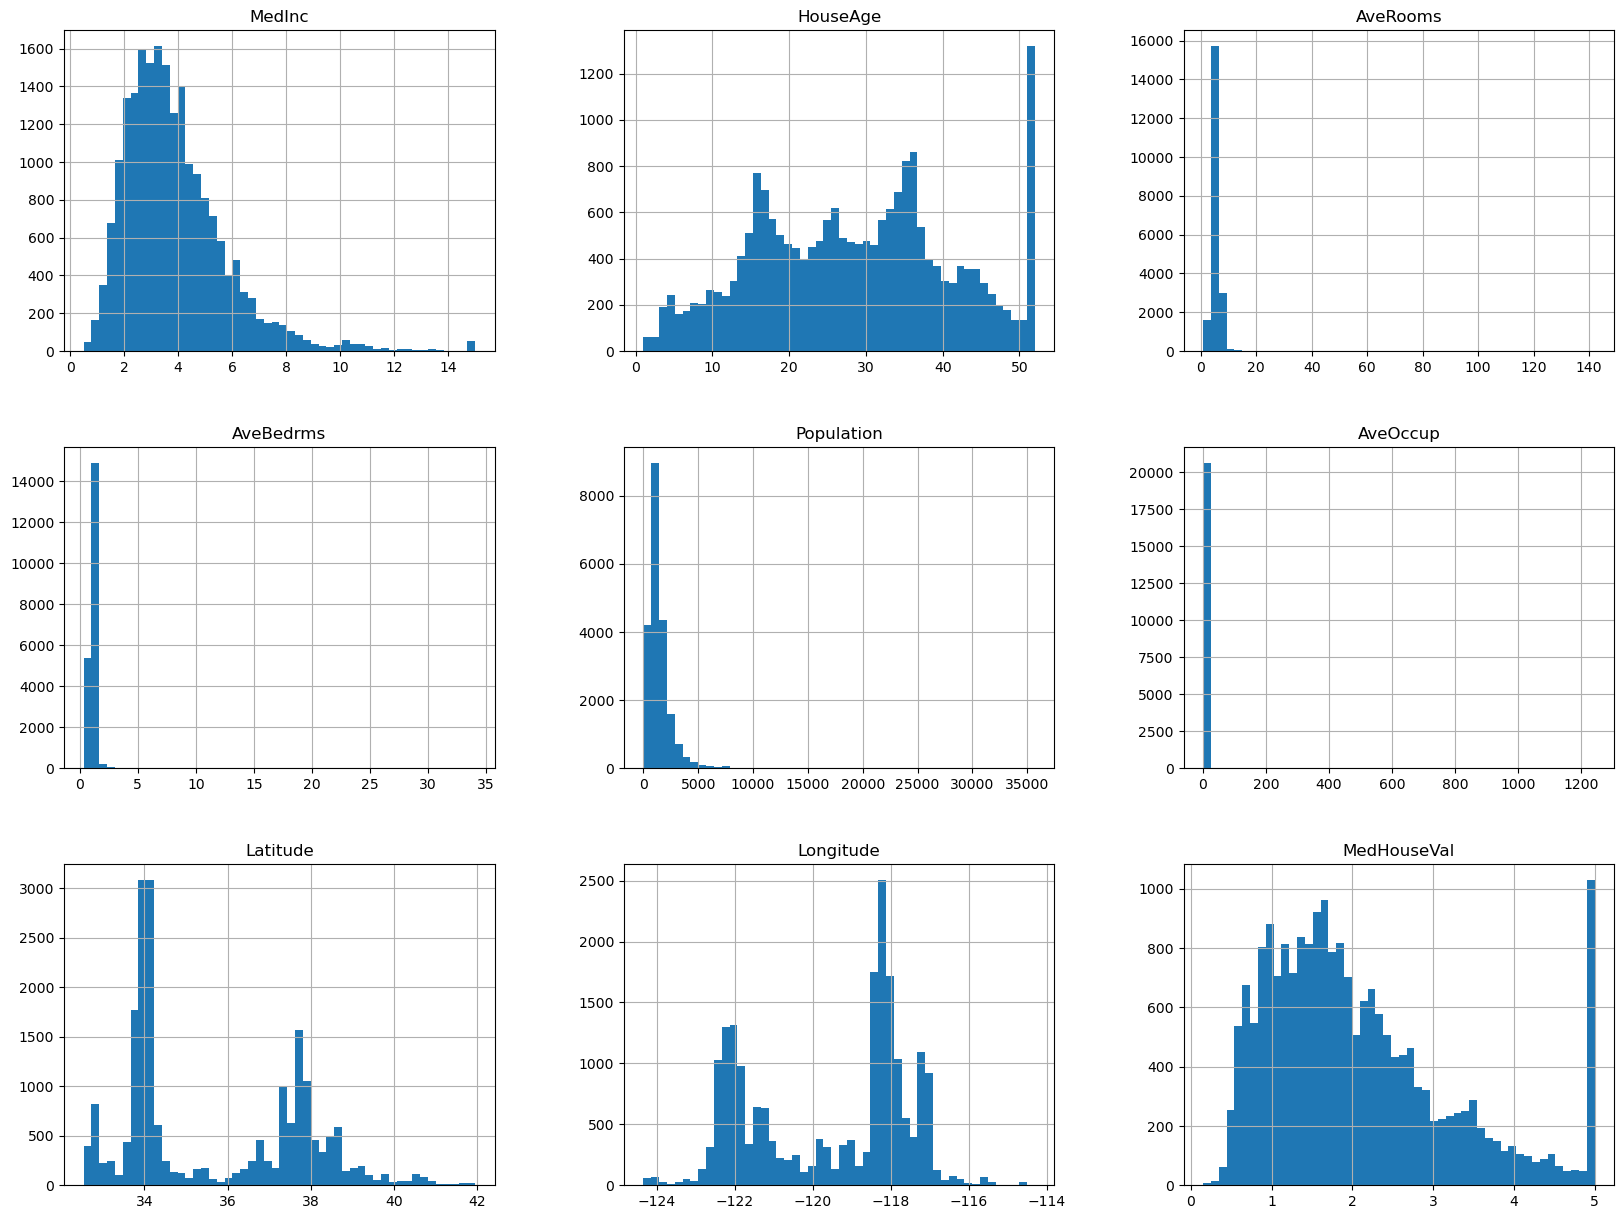

In [2]:

def plot_hist():
    california_housing.frame.hist(bins=50, figsize=(20,15))
    plt.show()
plot_hist()

## Partie I. Régression linéaire simple

Calculez la matrice de corrélations.

* I.1) Si vous deviez choisir une seule variable pour réaliser une régression linéaire simple, laquelle choisiriez-vous ? Pourquoi ? 

In [3]:
corr_matrix = california_housing.frame.corr()

best_one = corr_matrix["MedInc"].sort_values(ascending=False)
print(best_one)
# Choisir MedHouseVal car forte corrélation avec la target MedInc

MedInc         1.000000
MedHouseVal    0.688075
AveRooms       0.326895
AveOccup       0.018766
Population     0.004834
Longitude     -0.015176
AveBedrms     -0.062040
Latitude      -0.079809
HouseAge      -0.119034
Name: MedInc, dtype: float64


Nous voudrons créer un modèle $ \hat{y} = ax + b $, où $ \hat{y} $ est la prédiction du prix médian des maisons par quartier et $x$ est la caractéristique choisie en I.1.

* I.2) Quelles sont les valeurs optimales de $ a $ et $ b $ ? 

In [14]:
def moindre_carre_a_b(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    x_var = x.var()
    y_var = y.var()
    xy = x * y
    xy_mean = xy.mean()
    a = (xy_mean - x_mean * y_mean) / x_var
    b = y_mean - a * x_mean
    return a, b
x = california_housing.frame["MedHouseVal"]
y = california_housing.frame["MedInc"]
a,b = moindre_carre_a_b(x, y)
print("Notre modèle est y = {} * x + {}".format(a,b))
print("Les valeurs oprimales sont donc a = {} et b = {}".format(a,b))

Notre modèle est y = 1.1327613093798485 * x + 1.527488342761178
Les valeurs oprimales sont donc a = 1.1327613093798485 et b = 1.527488342761178


* I.3) Quelle est la valeur de $R^2$ ? Est-ce un bon ajustement ? Commentez
* I.4) Tracez la courbe de régression sur le nuage de points entre la sortie désirée et l'entrée

In [5]:
def calculate_r2(x, y, a, b):
    y_mean = y.mean()
    y_pred = a * x + b
    ss_res = ((y - y_pred) ** 2).sum()
    ss_tot = ((y - y_mean) ** 2).sum()
    return 1 - ss_res / ss_tot

r2 = calculate_r2(x, y, a, b)

In [6]:
from sklearn.linear_model import LinearRegression

# Création du modèle de régression linéaire
model = LinearRegression()

# Conversion de la série en DataFrame
x_reshaped = x.to_frame()

# Entrainement du modèle
model.fit(x_reshaped, y)

# Prédiction
y_pred = model.predict(x_reshaped)

r2 = model.score(x_reshaped, y)
print("Coefficient de détermination R^2:", r2)


Coefficient de détermination R^2: 0.4734474918071989


Les deux méthodes de calcul du $R^2$ nous ont donné une valeur similaire : $R^2 = 0.47$ environ.
La capacité du modèle à prévoir les changements dans la variable dépendante est donc modérée, ce qui suggère que d'autres facteurs non inclus dans le modèle pourraient également affecter les résultats. 

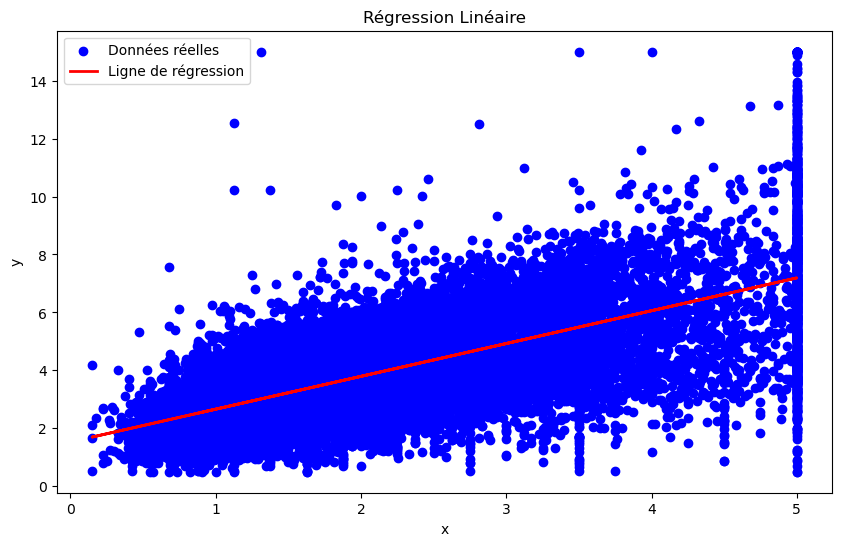

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Données réelles')
plt.plot(x, y_pred, color='red', linewidth=2, label='Ligne de régression')

plt.title('Régression Linéaire')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()


* I.5) Quelle est l'erreur RMS de prédiction ? (en moyenne sur toutes les observations)

In [18]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

df = california_housing.frame


y = df["MedHouseVal"]  # Prix médian des maisons : à prédire
X = df.drop("MedHouseVal", axis=1)  # Toutes les autres caractéristiques

# Données pour d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle de régression linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Prédiction et calcule du RMS
y_pred = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, y_pred)
lin_rmse = np.sqrt(lin_mse)

print("Erreur RMS pour la prédiction du prix médian des maisons:", lin_rmse)

Erreur RMS pour la prédiction du prix médian des maisons: 0.745581383012776


Une erreur RMS de 0.745 signifie que, lorsque le prix des maisons est donné en centaines de milliers de dollars, le modèle de prédiction se trompe en moyenne d'environ 74 558 $. Cette erreur peut paraître grande et suggère que le modèle pourrait être amélioré. Parfois, cette marge d'erreur est due à la complexité des données ou à des faiblesses dans le modèle utilisé.

Pour améliorer le modèle, nous allons essayer des techniques de régression plus avancées.

## Partie II. Régression multilinéaire

Maintenant réalisez une régression linéaire en utilisant toutes les caractéristiques disponibles. 

* II.1) Quelle est l'erreur de prédiction ?
* II.2) Quelle est la valeur de $R^2$ ? L'ajustement est-il meilleur qu'avec une seule variable d'entrée ?
* II.3) Quels sont les coefficients associés aux variables d'entrée, ainsi que le terme indépendant ?

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = california_housing.frame["MedInc"]

def multilinear_regression():
    X = california_housing.frame.drop("MedInc", axis=1)
    y = california_housing.frame["MedInc"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)
    lin_mse = mean_squared_error(y_test, y_pred)
    lin_rmse = lin_mse ** 0.5
    print("Linear regression RMSE: ", lin_rmse)
    print("Linear regression R2: ", lin_reg.score(X_test, y_test))

multilinear_regression()

#On a un R2 plus proche de 1 et un RMSE plus proche de 0 avec la régression linéaire multiple. On peut donc dire que ce modèle est meilleur que le précédent. Cependant
#on peut encore l'améliorer en utilisant un modèle plus complexe.

Linear regression RMSE:  1.0515702470669077
Linear regression R2:  0.6875602314945055


Maintenant nous allons introduire un terme de régularisation, donc la nouvelle fonction de coût est : $$ J' = J + \alpha\sum_{i}{w_i^2} $$
* II.4) Quelle est la valeur optimale du paramètre $\alpha$ ? (Trouvez-la empiriquement) 
* II.5) Quelle est l'erreur RMS avec $\alpha$ optimal ?

In [10]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Ensemble des valeurs de alpha à tester
alphas = np.logspace(-6, 6, 13)  # valeurs de alpha sur une échelle logarithmique

# Création du modèle de régression Ridge avec validation croisée
model_ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Entraînement du modèle
model_ridge_cv.fit(x_reshaped, y)

# Meilleur alpha trouvé
optimal_alpha = model_ridge_cv.alpha_
print("Valeur optimale de alpha :", optimal_alpha)

Valeur optimale de alpha : 1.0


In [11]:
# Nouvelle instance de Ridge avec alpha optimal
model_ridge = Ridge(alpha=optimal_alpha)

# Entraînement du nouveau modèle Ridge avec l'alpha explicite
model_ridge.fit(x_reshaped, y)

# Prédiction avec le nouveau modèle Ridge
y_pred_explicit = model_ridge.predict(x_reshaped)

mse = mean_squared_error(y, y_pred_explicit)
rms = np.sqrt(mse)
print("Erreur RMS avec alpha optimal :", rms)


NameError: name 'Ridge' is not defined


L'erreur RMS de $1.3785$ montre que le modèle Ridge est assez précis pour des tâches où une petite marge d'erreur est acceptable, car il dévie de moins de 10% de la valeur maximale de $y$ ($y \in [0, 14]$).

Ajoutez des variables polynomiales d'ordre $o=2$ aux variables déjà disponibles. Comparez la régression avec et sans régularisation (RMSE, $R^2$)
* II.6) Laquelle donne des meilleurs résultats ? Pourquoi ?  

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# Créer des caractéristiques polynomiales d'ordre 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(x_reshaped)
X_poly = np.hstack((x_reshaped, X_poly))


# Modèle de régression linéaire
model_lr = LinearRegression()
model_lr.fit(X_poly, y)
y_pred_lr = model_lr.predict(X_poly)

# Calcul du RMSE et du R^2
rmse_lr = np.sqrt(mean_squared_error(y, y_pred_lr))
r2_lr = r2_score(y, y_pred_lr)

print(f"Régression Linéaire - RMSE: {rmse_lr}, R^2: {r2_lr}")

# Définition des valeurs de alpha à tester
alphas = np.logspace(-6, 6, 13)

# Création du modèle RidgeCV
model_ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
model_ridge_cv.fit(X_poly, y)

# Utilisation du modèle Ridge avec alpha optimal
y_pred_ridge = model_ridge_cv.predict(X_poly)

# Calcul du RMSE et du R^2
rmse_ridge = np.sqrt(mean_squared_error(y, y_pred_ridge))
r2_ridge = r2_score(y, y_pred_ridge)

print(f"Régression Ridge - RMSE: {rmse_ridge}, R^2: {r2_ridge}")
print(f"Alpha optimal utilisé dans Ridge: {model_ridge_cv.alpha_}")

#code à revoir

Régression Linéaire - RMSE: 1.3785346767639794, R^2: 0.47346076735361387
Régression Ridge - RMSE: 1.378534679936318, R^2: 0.47346076493022804
Alpha optimal utilisé dans Ridge: 1.0


## Partie III. Régression non linéaire avec réseaux de neurones

Construisez et entraînez un réseau de neurones type Perceptron Multicouche (PMC) à $N_{layer} = 3$ couches et avec $m=5$ neurones dans la couche cachée.

N'oubliez pas de normaliser les données en prétraitement. 

In [ ]:
#Ecrivez votre code ici


* III.1) Quelle sont les prix prédits pour les dix premières observations ?
* III.2) Quelle est l'erreur RMS d'apprentissage ?

In [ ]:
#Ecrivez votre code ici

Réalisez une validation croisée type *K-Fold* avec $K=10$ (n'oubliez pas de mélanger les données préalablement)

* III.3) Quelle sont les erreurs RMS d'apprentissage et de test ? (Moyenne et écart-type)

In [ ]:
#Ecrivez votre code ici

Optimisez le nombre de neurones $m$ dans la couche cachée (Piste : réalisez la validation croisée pour différentes valeurs de $m$)

* III.4) Quelle est la valeur optimale de $m$ ? Pourquoi ? 

In [ ]:
#Ecrivez votre code ici

Pour une validation-croisée type K-Fold avec $K=10$ (mélangez l'ordre des observations), remplissez le tableau de RMSE de test ci-dessous selon les différents types de régression.

| Type de régression | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 | Fold 6 | Fold 7 | Fold 8 | Fold 9 | Fold 10 |
|--------------------|---------|--------|--------|-------|--------|-------|---------|--------|--------|---------|
| Linéaire simple    |  |  |  |  |  |  |  |  |  |  |
| Multilinéaire sans régul.    |  |  |  |  |  |  |  |  |  |  |
| Multilinéaire avec régul.    |  |  |  |  |  |  |  |  |  |  |
| Polynomiale sans régul.    |  |  |  |  |  |  |  |  |  |  |
| Polynomiale avec régul.    |  |  |  |  |  |  |  |  |  |  |
| Non linéaire avec NN    |  |  |  |  |  |  |  |  |  |  |

* III.5) Quelle est la méthode de régression la plus adaptée pour ce problème ? Justifiez
